In [1]:
from IPython import display
%matplotlib inline
import cv2
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys, shutil
import torch
import omegaconf
import time
import torch

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.params import import_parameters

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# produce a display to render image
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

In [3]:
# Define model working directorys
model_filename = 'saved_model'
work_dir = os.path.join(os.getcwd(), model_filename)
print(work_dir)

/home/qt21590/Documents/Projects/tactile_gym_mbrl/mbrl-lib/notebooks/saved_model


In [4]:
# Load the environment 
env_name = 'object_push-v0'
env_kwargs_file = 'env_kwargs'
env_kwargs_dir = os.path.join(work_dir, env_kwargs_file)
env_kwargs = omegaconf.OmegaConf.load(env_kwargs_dir)

env = gym.make(env_name, **env_kwargs)
seed = 0
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

argv[0]=
Loaded EGL 1.5 after reload.


pybullet build time: Mar  8 2021 17:26:24


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [5]:
# Get cfg and agent cfg
config_file = 'cfg_dict'
config_dir = os.path.join(work_dir, config_file)
cfg = omegaconf.OmegaConf.load(config_dir)
trial_length= cfg.overrides.trial_length

agent_config_file = 'agent_cfg'
agent_config_dir = os.path.join(work_dir, agent_config_file)
agent_cfg = omegaconf.OmegaConf.load(agent_config_dir)

# Re-map device
map_location = None
if cfg['dynamics_model']['device'] != device:
    cfg['dynamics_model']['device'] = device
    agent_cfg['optimizer_cfg']['device'] = device
    map_location = torch.device(device)
    
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape, work_dir)
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

# Create dyanmics, replay buffer and agent 
# dynamics_model.load(work_dir, map_location=map_location)
# replay_buffer.load(work_dir)
# dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats  

# Create agent 
agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


Terminated at step 313 with reward -51.25984681425869, goal reached: True
Terminated at step 327 with reward -95.90288865518066, goal reached: True
Terminated at step 351 with reward -65.78354705417657, goal reached: True
Terminated at step 327 with reward -52.9299997531639, goal reached: True
Terminated at step 250 with reward -113.85833696438247, goal reached: True
Terminated at step 360 with reward -62.646986633545886, goal reached: True
Terminated at step 323 with reward -55.67988597480501, goal reached: True
Terminated at step 319 with reward -54.68238568360689, goal reached: True
Terminated at step 319 with reward -57.80248865201081, goal reached: True
Terminated at step 368 with reward -72.16672200239539, goal reached: True
The average reward over 10 episodes is -68.27130881875263


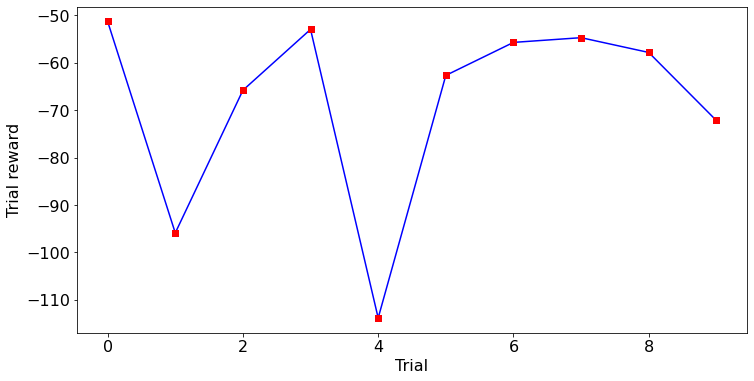

In [6]:
# Main PETS loop
num_test_trials = 10
all_rewards = []
evaluation_result = []
goal_reached = []
plan_time = 0.0
train_time = 0.0
save_vid = True
render = True

if save_vid:
    record_every_n_frames = 1
    render_img = env.render(mode="rgb_array")
    render_img_size = (render_img.shape[1], render_img.shape[0])
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        os.path.join(work_dir, "evaluated_policy.mp4"),
        fourcc,
        24.0,
        render_img_size,
    )

for trial in range(num_test_trials):
    obs = env.reset()    
    agent.reset()
    
    done = False
    trial_reward = 0.0
    trial_pb_steps = 0.0
    steps_trial = 0
    if "goal_excluded" in env.observation_mode:
        evaluation_result.append(np.hstack([trial, 
                                            steps_trial, 
                                            trial_pb_steps,
                                            obs[0:3], 
                                            obs[7:10], 
                                            env.goal_pos_workframe, 
                                            trial_reward, 
                                            False,
                                            done]))
    else:
        evaluation_result.append(np.hstack([trial, 
                                            steps_trial, 
                                            trial_pb_steps,
                                            obs[0:3] + env.goal_pos_workframe, 
                                            obs[7:10] + env.goal_pos_workframe, 
                                            env.goal_pos_workframe, 
                                            trial_reward, 
                                            False,
                                            done]))

    while not done:

        # --- Doing env step using the agent and adding to model dataset ---
        start_plan_time = time.time()
        action = agent.act(obs, **{})
        next_obs, reward, done, info = env.step(action)
        plan_time = time.time() - start_plan_time

        if render:
            render_img = env.render(mode="rgb_array")
        else:
            render_img = None
        
        obs = next_obs
        trial_reward += reward
        trial_pb_steps += info["num_of_pb_steps"]
        steps_trial += 1
        if "goal_excluded" in env.observation_mode:
            evaluation_result.append(np.hstack([trial, 
                                                steps_trial, 
                                                trial_pb_steps * env._sim_time_step,
                                                obs[0:3], 
                                                obs[7:10], 
                                                env.goal_pos_workframe, 
                                                trial_reward, 
                                                info["tip_in_contact"],
                                                done]))
        else:
            evaluation_result.append(np.hstack([trial, 
                                                steps_trial, 
                                                trial_pb_steps * env._sim_time_step,
                                                obs[0:3] + env.goal_pos_workframe, 
                                                obs[7:10] + env.goal_pos_workframe, 
                                                env.goal_pos_workframe, 
                                                trial_reward, 
                                                info["tip_in_contact"],
                                                done]))

         # use record_every_n_frames to reduce size sometimes
        if save_vid and steps_trial % record_every_n_frames == 0:

            # warning to enable rendering
            if render_img is None:
                sys.exit('Must be rendering to save video')

            render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
            out.write(render_img)

        if steps_trial == trial_length:
            break
    
    print("Terminated at step {} with reward {}, goal reached: {}".format(steps_trial, trial_reward, env.single_goal_reached))
    all_rewards.append(trial_reward)

    # save goal reached data during training
    if env.single_goal_reached:
        goal_reached.append(trial_reward)
    else:
        goal_reached.append(0)

if save_vid:
    out.release()

print("The average reward over {} episodes is {}".format(num_test_trials, np.mean(all_rewards)))

# Save data 
evaluation_result = np.array(evaluation_result)
data_columns = ['trial','trial_steps', 'time_steps', 'tcp_x','tcp_y','tcp_z','contact_x', 'contact_y', 'contact_z', 'goal_x', 'goal_y', 'goal_z', 'rewards', 'contact', 'dones']
df = pd.DataFrame(evaluation_result, columns = data_columns)
pd.DataFrame(evaluation_result).to_csv(os.path.join(work_dir, "evaluation_results.csv"))

# plot evaluation results
evaluation_result_directory = os.path.join(work_dir, "evaluation_result")
if not os.path.exists(evaluation_result_directory):
    os.mkdir(evaluation_result_directory)
else:
    for filename in os.listdir(evaluation_result_directory):
        file_path = os.path.join(evaluation_result_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def plot_and_save_push_plots(df, trials, directory):
    loss_contact = False
    for trial in range(trials):
        fig_xy, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df.query("trial==@trial")["tcp_x"], df.query("trial==@trial")["tcp_y"], "bs", label='tcp psosition')
        ax.plot(df.query("trial==@trial").query("contact==@loss_contact")["tcp_x"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_y"], "g+", markersize=20)
        ax.plot(df.query("trial==@trial")["contact_x"], df.query("trial==@trial")["contact_y"], "rs", label='contact psosition')
        ax.plot(df.query("trial==@trial").query("contact==@loss_contact")["contact_x"], df.query("trial==@trial").query("contact==@loss_contact")["contact_y"], "gx", markersize=20)
        ax.plot(df.query("trial==@trial")["goal_x"].iloc[0], df.query("trial==@trial")["goal_y"].iloc[0], "x", markersize=20, markeredgecolor="black", label="goal position")
        ax.set_xlabel("x workframe")
        ax.set_ylabel("y workframe")
        ax.set_xlim([0, 0.3])
        ax.set_ylim([-0.1, 0.1])
        ax.legend()
        fig_xy.savefig(os.path.join(directory, "workframe_plot_trial_{}.png".format(trial)))
        plt.close(fig_xy)

        fig_time_xy, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
        axs[0].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["tcp_x"] - df.query("trial==@trial")["goal_x"], "bs", label='tcp from goal')
        axs[0].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_x"] - df.query("trial==@trial").query("contact==@loss_contact")["goal_x"], "g+", markersize=20)
        axs[0].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["contact_x"] - df.query("trial==@trial")["goal_x"], "rs", label='contact from goal')
        axs[0].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["contact_x"]- df.query("trial==@trial").query("contact==@loss_contact")["goal_x"], "gx", markersize=20)
        axs[0].set_xlabel("Time steps (s)")
        axs[0].set_ylabel("x axis workframe")
        axs[0].set_ylim([-0.3, 0.1])
        axs[0].legend()
        axs[1].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["tcp_y"] - df.query("trial==@trial")["goal_y"], "bs", label='tcp')
        axs[1].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_y"] - df.query("trial==@trial").query("contact==@loss_contact")["goal_y"], "g+", markersize=20)
        axs[1].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["contact_y"] - df.query("trial==@trial")["goal_y"], "rs", label='contact from goal')
        axs[1].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["contact_y"] - df.query("trial==@trial").query("contact==@loss_contact")["goal_y"], "gx", markersize=20)
        axs[1].set_xlabel("Time steps (s)")
        axs[1].set_ylabel("y axis workframe")
        axs[1].set_ylim([-0.2, 0.2])
        axs[1].legend()
        fig_time_xy.savefig(os.path.join(directory, "time_plot_trial_{}.png".format(trial)))
        plt.close(fig_time_xy)

plot_and_save_push_plots(df, num_test_trials, evaluation_result_directory)

# Plot evaluation results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_rewards, 'bs-', goal_reached, 'rs')
ax.set_xlabel("Trial")
ax.set_ylabel("Trial reward")
fig.savefig(os.path.join(work_dir, "evaluation_output.png"))


In [8]:
value = False
df.query("contact==@value")

,trial,trial_steps,time_steps,tcp_x,tcp_y,tcp_z,contact_x,contact_y,contact_z,goal_x,goal_y,goal_z,rewards,contact,dones
0,0.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,-0.002932,0.0,0.000000,0.0,0.0
371,1.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,0.081320,0.0,0.000000,0.0,0.0
723,2.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.131284,0.090000,0.0,0.000000,0.0,0.0
1080,3.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,0.081728,0.0,0.000000,0.0,0.0
1429,4.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,0.046337,0.0,0.000000,0.0,0.0
1809,5.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,-0.049114,0.0,0.000000,0.0,0.0
2174,6.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.193069,0.090000,0.0,0.000000,0.0,0.0
2520,6.0,346.0,23.508333,0.253496,7.084626e-02,0.0,0.263106,0.056595,0.0,0.193069,0.090000,0.0,-57.931954,0.0,0.0
2614,7.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.220220,0.090000,0.0,0.000000,0.0,0.0
3054,8.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.193065,-0.090000,0.0,0.000000,0.0,0.0
